![image.png](attachment:image.png)

##### **Good luck with taking your exam. Keep working and make your dreams all come true. Seeing the results of all of your hard work will make this struggle worth it. We’re all thinking of you.** 
<b><font color='blue'>AI-PRO Spark Team ITI</font></b>

## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

## To perform this task follow the following guiding steps:

### Create a spark session and import the required libraries

In [ ]:
!pip install pyspark 
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, IntegerType, TimestampType
spark = SparkSession.builder.appName("First Project").getOrCreate()

### Create a data schema programatically

In [ ]:
#sampleDF = spark.read.option("samplingRatio", 0.01).option("header", True).csv("/content/healthcare-dataset-stroke-data.csv")
schema = StructType([StructField("id", IntegerType(), False),
                     StructField("gender", StringType(), False),
                     StructField("age", DoubleType(), False),
                     StructField("hypertension", IntegerType(), False),
                     StructField("heart_disease", IntegerType(), False),
                     StructField("ever_married", StringType(), False),
                     StructField("work_type", StringType(), False),
                     StructField("Residence_type", StringType(), False),
                     StructField("avg_glucose_level", DoubleType(), False),
                     StructField("bmi", DoubleType(), False),
                     StructField("smoking_status", StringType(), False),
                    StructField("stroke", IntegerType(), False)])

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [ ]:
data = spark.read.csv("/content/healthcare-dataset-stroke-data.csv", header="true", schema=schema)

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [ ]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
data.show(10,truncate=False)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|id   |gender|age |hypertension|heart_disease|ever_married|work_type    |Residence_type|avg_glucose_level|bmi |smoking_status |stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|9046 |Male  |67.0|0           |1            |Yes         |Private      |Urban         |228.69           |36.6|formerly smoked|1     |
|51676|Female|61.0|0           |0            |Yes         |Self-employed|Rural         |202.21           |null|never smoked   |1     |
|31112|Male  |80.0|0           |1            |Yes         |Private      |Rural         |105.92           |32.5|never smoked   |1     |
|60182|Female|49.0|0           |0            |Yes         |Private      |Urban         |171.23           |34.4|smokes         |1     |
|1665 |Female|79.0|1           |0            |Yes      

In [ ]:
for coulmnName in data.columns:
  numOfNulls=data.where(F.col(coulmnName).isNull()).count()
  if (numOfNulls > 0):
    print(coulmnName , 'Has' ,numOfNulls)


bmi Has 201


### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [ ]:
data.select(F.min(F.col('age'))).show()

+--------+
|min(age)|
+--------+
|    0.08|
+--------+



In [ ]:
data=data.where(F.col('age')>2)
data.select(F.min(F.col('age'))).show()

+--------+
|min(age)|
+--------+
|     3.0|
+--------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [ ]:
data.select('gender','smoking_status').show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [ ]:
data.select('smoking_status').agg(F.countDistinct('smoking_status').alias('DistinctSmoking')).show()

+---------------+
|DistinctSmoking|
+---------------+
|              4|
+---------------+



In [ ]:
data.select('gender').agg(F.countDistinct('gender').alias('DistinctGender')).show()

+--------------+
|DistinctGender|
+--------------+
|             3|
+--------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline


In [ ]:
def Gender_column_Fun(col):
  if col == 'Male':
    return 1
  else:
    return 0

def Smoking_Status_column(col):
  if col == 'never smoked':
    return 0.0
  elif col == 'Unknown':
    return 0.5
  elif col== 'formerly smoked':
    return 0.75
  else:
    return 1.0

In [ ]:
gender_Indexed = F.udf(Gender_column_Fun, IntegerType())
dataInd = data.withColumn('gender', gender_Indexed('gender'))

Smoking_Status_Indexed = F.udf(Smoking_Status_column, DoubleType())
dataInd = dataInd.withColumn('smoking_status', Smoking_Status_Indexed('smoking_status'))

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [ ]:
dataInd.select('gender','smoking_status').show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



### Deal with null value according to your data analysis.

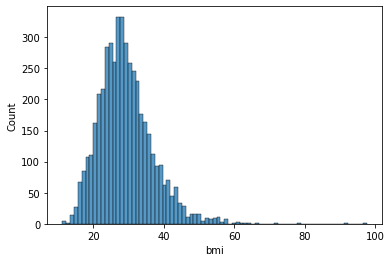

In [ ]:
import seaborn as sns
bmi = data.toPandas().bmi
#sns.countplot(x=bmi);
sns.histplot(x=bmi)
mean=29.2574

In [ ]:
data.select(F.mean(F.col('bmi'))).show()
dataInd=dataInd.fillna(mean,subset=['bmi'])

+------------------+
|          avg(bmi)|
+------------------+
|29.257489451476793|
+------------------+



In [ ]:
dataInd.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-------+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|    bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-------+--------------+------+
| 9046|     1|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|   36.6|          0.75|     1|
|51676|     0|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|29.2574|           0.0|     1|
|31112|     1|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|   32.5|           0.0|     1|
|60182|     0|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|   34.4|           1.0|     1|
| 1665|     0|79.0|           1|         

### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [ ]:
X_train, X_test = dataInd.randomSplit([0.8, 0.2], seed = 42)

In [ ]:
X_train.write.parquet("/content/train1.parquet")
X_test.write.parquet("/content/test1.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [ ]:
X_train = spark.read.parquet("/content/train1.parquet")
X_test = spark.read.parquet("/content/test1.parquet")

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [ ]:
categoricalCols = [field for (field, dataType) in dataInd.dtypes
                   if dataType == "string"]
categoricalCols

['ever_married', 'work_type', 'Residence_type']

In [ ]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [ ]:
numericCols = [field for (field,dataType) in data2.dtypes
              if ((dataType=='double')& (field!='stroke'))]
numericCols

['age', 'avg_glucose_level', 'bmi']

In [ ]:
assemblerInputs = oheOutputCols + numericCols +['gender','hypertension','heart_disease']
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'age',
 'avg_glucose_level',
 'bmi',
 'gender',
 'hypertension',
 'heart_disease']

In [ ]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'stroke', maxIter=10)

pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LR])

predictions = pipeline.fit(X_train).transform(X_test)
predictions.show()

+----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-------+--------------+------+------------------+---------------+--------------------+----------------+-------------+------------------+--------------------+--------------------+--------------------+----------+
|  id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|    bmi|smoking_status|stroke|ever_married_Index|work_type_Index|Residence_type_Index|ever_married_OHE|work_type_OHE|Residence_type_OHE|            features|       rawPrediction|         probability|prediction|
+----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-------+--------------+------+------------------+---------------+--------------------+----------------+-------------+------------------+--------------------+--------------------+--------------------+----------+
|  84|     1|55.0|           0|            0|       

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [ ]:
predictions.select('features').show()

+--------------------+
|            features|
+--------------------+
|[1.0,1.0,0.0,0.0,...|
|(12,[1,5,6,7,8],[...|
|(12,[0,1,6,7,8],[...|
|(12,[0,1,6,7,8],[...|
|[1.0,1.0,0.0,0.0,...|
|(12,[0,1,6,7,8],[...|
|[1.0,0.0,1.0,0.0,...|
|(12,[0,2,5,6,7,8]...|
|(12,[4,6,7,8],[1....|
|(12,[0,1,6,7,8,9]...|
|(12,[0,3,6,7,8,9]...|
|(12,[1,6,7,8,10,1...|
|(12,[1,6,7,8,9],[...|
|(12,[0,2,6,7,8],[...|
|(12,[0,1,6,7,8,10...|
|(12,[0,3,5,6,7,8]...|
|(12,[1,5,6,7,8],[...|
|[1.0,1.0,0.0,0.0,...|
|[1.0,0.0,0.0,1.0,...|
|(12,[1,5,6,7,8],[...|
+--------------------+
only showing top 20 rows



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [ ]:
evaluatorROC.evaluate(predictions)

0.4994475138121547

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

In [ ]:
ones = data2.groupBy("stroke").count().collect()[0][1]
zeros = data2.groupBy("stroke").count().collect()[1][1]

all = ones + zeros
ratio_zeros = zeros / all
ratio_ones = ones / all

In [ ]:
def weighted_col(x):
  if x == 0:
    return ratio_ones
  else:
    return ratio_zeros

In [ ]:
weighted_col_map_func = F.udf(weighted_col, DoubleType())
X_train = X_train.withColumn('weighted_col', weighted_col_map_func('stroke'))

In [ ]:
X_train.createOrReplaceTempView("X_train")
spark.sql("SELECT stroke, weighted_col FROM X_train").show()

+------+--------------------+
|stroke|        weighted_col|
+------+--------------------+
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     1|  0.9497467071935157|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
|     0|0.050253292806484294|
+------+--------------------+
only showing top 20 rows



In [ ]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'stroke', weightCol = 'weighted_col')

pipeline2 = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LR])
pred_W = pipeline2.fit(X_train).transform(X_test)
pred_W.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [ ]:
evaluatorROC.evaluate(pred_W)

0.7425131038390708

# GOOD LUCK
<b><font color='GREEN'>AI-PRO Spark Team ITI</font></b>

![image-3.png](attachment:image-3.png)